# <p style="text-align: center;">A first simple LSTM network<br>for time series prediction
</p>

<p style="text-align: center;">
 by Prof. Dr.-Ing. Jürgen Brauer, http://www.juergenbrauer.org
</p>

## Table of Contents:

1. Generate some time series data
2. Plot the time series data
3. Prepare training data
4. Building and training the LSTM network model using Keras
5. Test prediction performance on train data
6. Experiments regarding LOOK_BACK and NR_TRAIN_EPOCHS
7. Long-term predictions
8. Experiments with more complex time series

## 1. Generate some time series data

In [35]:
# Experiment settings
LOOK_BACK = 6
NR_LSTM_CELLS = 8
NR_TRAIN_EPOCHS = 2000
SCALE_TIME_SERIES = True


import numpy as np
data_x = [x for x in np.arange(0,6*np.pi, np.pi/8)]

# test time series #1
# cos(x): a periodic time series
#time_series = [np.cos(x) for x in data_x]

# test time series #2
# x/10.0+cos(x): i.e. time series has an underlying trend
#time_series = [x/10.0+np.cos(x) for x in data_x]

# test time series #3
# x+cos(x): i.e. time series has an underlying trend
time_series = [x+np.cos(x) for x in data_x]

if SCALE_TIME_SERIES:
    
    # Rescale time series such that values are in [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_time_series = scaler.fit_transform(np.array(time_series).reshape(-1,1))
    scaled_time_series = scaled_time_series.reshape(-1).tolist()
    time_series = scaled_time_series


print("Length of time_series is", len(time_series))
print("time_series=", time_series)


Length of time_series is 48
time_series= [0.0, 0.017223391261201856, 0.026794625340736164, 0.030509151869715076, 0.031054051112636594, 0.031598950355558125, 0.03531347688453702, 0.044884710964071345, 0.0621081022252732, 0.08761412873532341, 0.12077231242704119, 0.15978720366931431, 0.20197172219764498, 0.24415624072597558, 0.2831711319682487, 0.31632931565996647, 0.34183534217001676, 0.35905873343121864, 0.36862996751075294, 0.3723444940397318, 0.37288939328265336, 0.3734342925255749, 0.3771488190545537, 0.3867200531340881, 0.40394344439528995, 0.42944947090534025, 0.46260765459705794, 0.501622545839331, 0.5438070643676617, 0.5859915828959922, 0.6250064741382653, 0.6581646578299831, 0.6836706843400334, 0.7008940756012353, 0.7104653096807696, 0.7141798362097486, 0.71472473545267, 0.7152696346955916, 0.7189841612245704, 0.7285553953041047, 0.7457787865653066, 0.7712848130753567, 0.8044429967670746, 0.8434578880093477, 0.8856424065376781, 0.9278269250660088, 0.9668418163082819, 1.0]


## 2. Plot the time series data

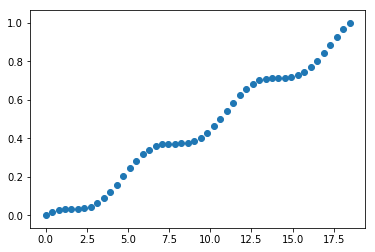

In [36]:
import matplotlib.pyplot as plt
plt.scatter(data_x,time_series,label='ro')
plt.show()

## 3. Prepare training data

For the training of the LSTM we need training samples of the form

    [value_t-2, value_t-1, value_t  ] --> value_t+1
    [value_t-1, value_t  , value_t+1] --> value_t+2
    [value_t  , value_t+1, value_t+2] --> value_t+3
    ...
    etc.


In [37]:
# define a helper function to convert a time series array
# into two NumPy arrays
# train_input (containing LOOK_BACK samples)
# and
# train_output (containing 1 prediction sample)

def split_into_train_samples(dataset, LOOK_BACK=1):
   train_input, train_output = [], []
   for i in range(len(dataset)-LOOK_BACK):
      a = dataset[i:i+LOOK_BACK]
      train_input.append(a)
      train_output.append(dataset[i + LOOK_BACK])
   return np.array(train_input), np.array(train_output)


# define how NumPy shall print matrices
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True) # do not use scientific "e"-notation

train_input, train_output = split_into_train_samples( time_series, LOOK_BACK)
print("train_input has shape", train_input.shape)
print("train_output has shape", train_output.shape)
print("train_input=", train_input)
print("train_output=", train_output)


train_input has shape (42, 6)
train_output has shape (42,)
train_input= [[0.   0.02 0.03 0.03 0.03 0.03]
 [0.02 0.03 0.03 0.03 0.03 0.04]
 [0.03 0.03 0.03 0.03 0.04 0.04]
 [0.03 0.03 0.03 0.04 0.04 0.06]
 [0.03 0.03 0.04 0.04 0.06 0.09]
 [0.03 0.04 0.04 0.06 0.09 0.12]
 [0.04 0.04 0.06 0.09 0.12 0.16]
 [0.04 0.06 0.09 0.12 0.16 0.2 ]
 [0.06 0.09 0.12 0.16 0.2  0.24]
 [0.09 0.12 0.16 0.2  0.24 0.28]
 [0.12 0.16 0.2  0.24 0.28 0.32]
 [0.16 0.2  0.24 0.28 0.32 0.34]
 [0.2  0.24 0.28 0.32 0.34 0.36]
 [0.24 0.28 0.32 0.34 0.36 0.37]
 [0.28 0.32 0.34 0.36 0.37 0.37]
 [0.32 0.34 0.36 0.37 0.37 0.37]
 [0.34 0.36 0.37 0.37 0.37 0.37]
 [0.36 0.37 0.37 0.37 0.37 0.38]
 [0.37 0.37 0.37 0.37 0.38 0.39]
 [0.37 0.37 0.37 0.38 0.39 0.4 ]
 [0.37 0.37 0.38 0.39 0.4  0.43]
 [0.37 0.38 0.39 0.4  0.43 0.46]
 [0.38 0.39 0.4  0.43 0.46 0.5 ]
 [0.39 0.4  0.43 0.46 0.5  0.54]
 [0.4  0.43 0.46 0.5  0.54 0.59]
 [0.43 0.46 0.5  0.54 0.59 0.63]
 [0.46 0.5  0.54 0.59 0.63 0.66]
 [0.5  0.54 0.59 0.63 0.66 0.68]
 [0.

## 4. Building and training the LSTM network model using Keras

Preparing the input to a LSTM can be a little bit tricky!

However, Jason Brownlee has a blog which provides a
gentle introduction into the topic:

"The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

    - Samples. One sequence is one sample. A batch is comprised of one or more samples.
    - Time Steps. One time step is one point of observation in the sample.
    - Features. One feature is one observation at a time step.
    
When defining the input layer of your LSTM network,
the network assumes you have 1 or more samples and
requires that you specify the number of time steps and
the number of features. You can do this by specifying
a tuple to the “input_shape” argument.

For example, the model below defines an input layer
that expects 1 or more samples, 50 time steps, and 2 features.

    model = Sequential()
    model.add(LSTM(32, input_shape=(50, 2)))
    model.add(Dense(1))"

Quotation source:
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# 1.
# Configure LSTM model & training
BATCH_SIZE = train_input.shape[0]

# 2.
# Prepare training data for the Keras LSTM model
# Keras expects LSTM input to be 3-dimensional!
# Should have shape: [samples, time steps, features]
train_input_reshaped  = train_input.reshape( (train_input.shape[0], LOOK_BACK, 1) )
print("Shape of train_input_reshaped is", train_input_reshaped.shape)
#print("train_input_reshaped=", train_input_reshaped)

# 3.
# Build the LSTM model using Keras
model = Sequential()
model.add( LSTM(NR_LSTM_CELLS, input_shape = (LOOK_BACK,1)) )
model.add( Dense(1) )
model.compile(loss='mean_squared_error', optimizer='sgd')

# 4.
# Train the LSTM model
model.fit(train_input_reshaped,
          train_output,
          batch_size=BATCH_SIZE,
          shuffle=False,          
          epochs=NR_TRAIN_EPOCHS)

Shape of train_input_reshaped is (42, 6, 1)
Epoch 1/2000
42/42 [==============================] - 1s 13ms/step - loss: 0.0615
Epoch 2/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0561
Epoch 3/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0513
Epoch 4/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0470
Epoch 5/2000
42/42 [==============================] - 0s 118us/step - loss: 0.0431
Epoch 6/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0396
Epoch 7/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0365
Epoch 8/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0338
Epoch 9/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0313
Epoch 10/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0291
Epoch 11/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0271
Epoch 12/2000
42/42 [=====================

Epoch 99/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0074
Epoch 100/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0074
Epoch 101/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0074
Epoch 102/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0073
Epoch 103/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0073
Epoch 104/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0073
Epoch 105/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0072
Epoch 106/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0072
Epoch 107/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0072
Epoch 108/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0071
Epoch 109/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0071
Epoch 110/2000
42/42 [==============================] - 0s 107us/step -

Epoch 196/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0051
Epoch 197/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0051
Epoch 198/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0050
Epoch 199/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0050
Epoch 200/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0050
Epoch 201/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0050
Epoch 202/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0050
Epoch 203/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0050
Epoch 204/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0049
Epoch 205/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0049
Epoch 206/2000
42/42 [==============================] - 0s 83us/step - loss: 0.0049
Epoch 207/2000
42/42 [==============================] - 0s 119us/ste

Epoch 293/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0037
Epoch 294/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0037
Epoch 295/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0037
Epoch 296/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0036
Epoch 297/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0036
Epoch 298/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0036
Epoch 299/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0036
Epoch 300/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0036
Epoch 301/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0036
Epoch 302/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0036
Epoch 303/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0036
Epoch 304/2000
42/42 [==============================] - 0s 95us/step 

Epoch 390/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0029
Epoch 391/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0029
Epoch 392/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0028
Epoch 393/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0028
Epoch 394/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0028
Epoch 395/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0028
Epoch 396/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0028
Epoch 397/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0028
Epoch 398/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0028
Epoch 399/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0028
Epoch 400/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0028
Epoch 401/2000
42/42 [==============================] - 0s 83us/step 

Epoch 487/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0024
Epoch 488/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0024
Epoch 489/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0024
Epoch 490/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0024
Epoch 491/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0024
Epoch 492/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0024
Epoch 493/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0024
Epoch 494/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0024
Epoch 495/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0024
Epoch 496/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0024
Epoch 497/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0024
Epoch 498/2000
42/42 [==============================] - 0s 143us/ste

Epoch 584/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0021
Epoch 585/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0021
Epoch 586/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0021
Epoch 587/2000
42/42 [==============================] - 0s 167us/step - loss: 0.0021
Epoch 588/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0021
Epoch 589/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0021
Epoch 590/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0021
Epoch 591/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0021
Epoch 592/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0021
Epoch 593/2000
42/42 [==============================] - 0s 83us/step - loss: 0.0021
Epoch 594/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0021
Epoch 595/2000
42/42 [==============================] - 0s 119us/ste

Epoch 681/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0020
Epoch 682/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0020
Epoch 683/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0020
Epoch 684/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0020
Epoch 685/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0020
Epoch 686/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0020
Epoch 687/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0020
Epoch 688/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0020
Epoch 689/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0020
Epoch 690/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0020
Epoch 691/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0020
Epoch 692/2000
42/42 [==============================] - 0s 119us/s

Epoch 778/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0019
Epoch 779/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0019
Epoch 780/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0019
Epoch 781/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0019
Epoch 782/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0019
Epoch 783/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0019
Epoch 784/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0019
Epoch 785/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0019
Epoch 786/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0019
Epoch 787/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0019
Epoch 788/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0019
Epoch 789/2000
42/42 [==============================] - 0s 107us/ste

Epoch 875/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0019
Epoch 876/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0019
Epoch 877/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0019
Epoch 878/2000
42/42 [==============================] - 0s 203us/step - loss: 0.0019
Epoch 879/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0019
Epoch 880/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0019
Epoch 881/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0019
Epoch 882/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0019
Epoch 883/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0019
Epoch 884/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0019
Epoch 885/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0019
Epoch 886/2000
42/42 [==============================] - 0s 95us/st

Epoch 972/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 973/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 974/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 975/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 976/2000
42/42 [==============================] - 0s 167us/step - loss: 0.0018
Epoch 977/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 978/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 979/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 980/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 981/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 982/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 983/2000
42/42 [==============================] - 0s 95us/st

Epoch 1068/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1069/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1070/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1071/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1072/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1073/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1074/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1075/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1076/2000
42/42 [==============================] - 0s 83us/step - loss: 0.0018
Epoch 1077/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1078/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1079/2000
42/42 [==============================] - 0s 9

Epoch 1164/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 1165/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 1166/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1167/2000
42/42 [==============================] - 0s 167us/step - loss: 0.0018
Epoch 1168/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1169/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1170/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0018
Epoch 1171/2000
42/42 [==============================] - 0s 167us/step - loss: 0.0018
Epoch 1172/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0018
Epoch 1173/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0018
Epoch 1174/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1175/2000
42/42 [==============================]

Epoch 1260/2000
42/42 [==============================] - 0s 203us/step - loss: 0.0018
Epoch 1261/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1262/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 1263/2000
42/42 [==============================] - 0s 167us/step - loss: 0.0018
Epoch 1264/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1265/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1266/2000
42/42 [==============================] - 0s 83us/step - loss: 0.0018
Epoch 1267/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1268/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1269/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1270/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1271/2000
42/42 [==============================] -

Epoch 1356/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 1357/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0018
Epoch 1358/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1359/2000
42/42 [==============================] - 0s 167us/step - loss: 0.0018
Epoch 1360/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 1361/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0018
Epoch 1362/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1363/2000
42/42 [==============================] - 0s 83us/step - loss: 0.0018
Epoch 1364/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1365/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1366/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1367/2000
42/42 [==============================] 

Epoch 1452/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1453/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0018
Epoch 1454/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0018
Epoch 1455/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1456/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1457/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1458/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1459/2000
42/42 [==============================] - 0s 167us/step - loss: 0.0018
Epoch 1460/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1461/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1462/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1463/2000
42/42 [==============================] 

Epoch 1548/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1549/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1550/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1551/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1552/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1553/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1554/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0018
Epoch 1555/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1556/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0018
Epoch 1557/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1558/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1559/2000
42/42 [==============================] -

Epoch 1644/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0018
Epoch 1645/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1646/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0018
Epoch 1647/2000
42/42 [==============================] - 0s 203us/step - loss: 0.0018
Epoch 1648/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 1649/2000
42/42 [==============================] - 0s 191us/step - loss: 0.0018
Epoch 1650/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0018
Epoch 1651/2000
42/42 [==============================] - 0s 191us/step - loss: 0.0018
Epoch 1652/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0018
Epoch 1653/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0018
Epoch 1654/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0018
Epoch 1655/2000
42/42 [==============================]

Epoch 1740/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0017
Epoch 1741/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0017
Epoch 1742/2000
42/42 [==============================] - 0s 131us/step - loss: 0.0017
Epoch 1743/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0017
Epoch 1744/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1745/2000
42/42 [==============================] - 0s 144us/step - loss: 0.0017
Epoch 1746/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0017
Epoch 1747/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1748/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0017
Epoch 1749/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1750/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0017
Epoch 1751/2000
42/42 [==============================] 

Epoch 1836/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0017
Epoch 1837/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0017
Epoch 1838/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0017
Epoch 1839/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0017
Epoch 1840/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1841/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0017
Epoch 1842/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0017
Epoch 1843/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1844/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1845/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0017
Epoch 1846/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1847/2000
42/42 [==============================] - 

Epoch 1932/2000
42/42 [==============================] - 0s 203us/step - loss: 0.0017
Epoch 1933/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0017
Epoch 1934/2000
42/42 [==============================] - 0s 155us/step - loss: 0.0017
Epoch 1935/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0017
Epoch 1936/2000
42/42 [==============================] - 0s 179us/step - loss: 0.0017
Epoch 1937/2000
42/42 [==============================] - 0s 214us/step - loss: 0.0017
Epoch 1938/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1939/2000
42/42 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 1940/2000
42/42 [==============================] - 0s 119us/step - loss: 0.0017
Epoch 1941/2000
42/42 [==============================] - 0s 95us/step - loss: 0.0017
Epoch 1942/2000
42/42 [==============================] - 0s 143us/step - loss: 0.0017
Epoch 1943/2000
42/42 [==============================] 

## 5. Test prediction performance on train data

prediction has shape (42, 1)
train_output has shape (42,)


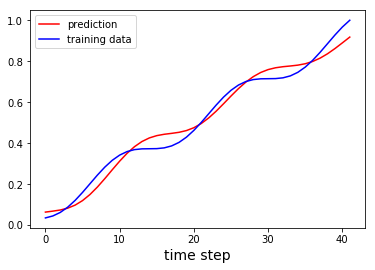

prediction_errors= [0.03 0.02 0.01 0.   0.02 0.04 0.05 0.06 0.06 0.05 0.03 0.01 0.01 0.04
 0.05 0.06 0.07 0.06 0.05 0.03 0.01 0.01 0.02 0.03 0.03 0.03 0.02 0.
 0.01 0.03 0.04 0.05 0.05 0.05 0.04 0.02 0.01 0.03 0.05 0.07 0.08 0.08]
mean_prediction_error= 0.036005619511991716


In [39]:
prediction = model.predict(train_input_reshaped)
print("prediction has shape", prediction.shape)
print("train_output has shape", train_output.shape)
#print(prediction)


plt.plot(prediction, label="prediction", color="red")
plt.plot(train_output, label="training data", color="blue")
plt.xlabel("time step", fontsize=14)
plt.legend()
plt.show()


prediction_errors = np.abs(prediction.reshape(prediction.shape[0]) - train_output)
mean_prediction_error = np.mean(prediction_errors)
print("prediction_errors=", prediction_errors)
print("mean_prediction_error=", mean_prediction_error)


## 6. Experiments regarding LOOK_BACK and NR_TRAIN_EPOCHS

#### Experiment #1:
Try LOOK_BACK=3 and NR_TRAIN_EPOCHS=500:<br>
You can see that the overall form of the predicted curve is ok, but the amplitude
and the phase is not correct<br>
mean prediction error: 0.38

#### Experiment #2:
Try LOOK_BACK=3 and NR_TRAIN_EPOCHS=1500:<br>
You can see that the overall form of the predicted curve is slightly better,
but there is still enough space to improve the amplitude and the phase<br>
mean prediction error: 0.22

#### Experiment #3:
Try LOOK_BACK=6 and NR_TRAIN_EPOCHS=1500:<br>
You can see that the overall form of the predicted curve is much better,
now amplitude and phase are very near to ground truth<br>
mean prediction error: 0.03
   
#### Experiment conclusions:

- Exp #2 shows: more training epochs help
- Exp #3 shows: more "input time steps" help



## 7. Long-term predictions

In the previous experiment we always took LOOK_BACK many values and predicted the next value. E.g., we have the sales figures for the last LOOK_BACK=5 days and we want to predict the sales figures for the next day.

However, in some applications we would like to do long-term predictions. E.g., we have just LOOK_BACK=5 sales figures of the last 5 days and we want to predict the sales figures for the next two weeks.

What can we do? We could use our predicted values as input for the next prediction round!

First prediction round:

    sales_t-5, sales_t-4, sales_t-3, sales_t-2, sales_t-1 --> pred_sales_t

Second prediction round:

    sales_t-4, sales_t-3, sales_t-2, sales_t-1, pred_sales_t --> pred_sales_t+1

Third prediction round:

    sales_t-3, sales_t-2, sales_t-1, pred_sales_t, pred_sales_t+1 --> pred_sales_t+2
    
...

Let's try this approach!

### Making a single prediction

First we need to learn how to do a single prediction. Then we can prepare the input data in each new prediction step such that we include the last prediction values.

In [40]:
# 1. Prepare training data such that we can use
#    LOOK_BACK many last time steps for the prediction
train_input, train_output = split_into_train_samples( time_series, LOOK_BACK)

# 2. Prepare input for a single prediction
single_input = np.array( [time_series[i] for i in range(0,LOOK_BACK)] )
# LSTM expects input to be [samples, time steps, features]
single_input_reshaped = single_input.reshape(1,LOOK_BACK,1)
single_prediction = model.predict(single_input_reshaped)
ground_truth = time_series[LOOK_BACK]
print("single_prediction has type", type(single_prediction))
print("single_prediction=", single_prediction[0][0])
print("ground_truth=", ground_truth)


single_prediction has type <class 'numpy.ndarray'>
single_prediction= 0.063706264
ground_truth= 0.03531347688453702


### Using predicted values as input for the next prediction step

Now we want to follow the idea mentioned above and put the predicted value into the input vector for the next prediction step.

I will now try a long term prediction for 42 time steps.


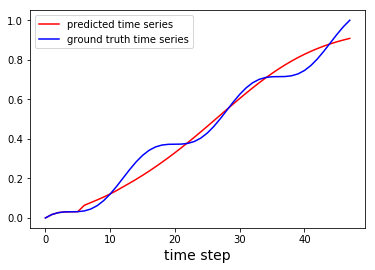

Len of predicted_time_series is 48
Len of time_series is 48
prediction_errors= [0.   0.   0.   0.   0.   0.   0.03 0.03 0.03 0.02 0.   0.02 0.04 0.07
 0.09 0.1  0.11 0.1  0.09 0.07 0.04 0.02 0.   0.02 0.03 0.03 0.03 0.02
 0.   0.01 0.02 0.03 0.03 0.02 0.   0.02 0.04 0.06 0.07 0.08 0.08 0.07
 0.05 0.03 0.   0.04 0.07 0.09]
mean_prediction_error= 0.037570058301534905


In [41]:
NR_PREDICTION_STEPS = min(50, len(time_series)-LOOK_BACK)
print("I will now try a long term prediction for",
      NR_PREDICTION_STEPS, "time steps.")

# 1.
# For the very first prediction vector
# we need some input data:
# here we take the first LOOK_BACK time steps
# from the ground truth data
predicted_time_series = [time_series[i] for i in range(0,LOOK_BACK)]

# 2. 
# now lets predict a new value for each coming
# time step based on past predicted values
for prediction_step in range(0,NR_PREDICTION_STEPS):

    # 2.1 
    # prepare the last LOOK_BACK values of the predicted
    # time series as input vector for the next prediction
    N = len(predicted_time_series)
    single_input_as_np_array = np.array( predicted_time_series[N-LOOK_BACK:N] )
    #print(single_input_as_np_array)
    
    # 2.2
    # LSTM expects input to be 3D dimensional!
    # It shall have the shape: [samples, time steps, features]
    single_input_reshaped = single_input_as_np_array.reshape(1,LOOK_BACK,1)
    single_prediction = model.predict(single_input_reshaped)
    
    # 2.3
    # get the predicted value as a scalar
    # Note: Keras provides us the prediction as a 2D NumPy matrix
    #       - for each input vector a prediction row
    #       - for each of the predicted values a column
    predicted_value = single_prediction[0][0]
    
    # 2.4
    # save the predicted value
    predicted_time_series.append( predicted_value )
    
    
# 3.
# plot the predicted time series and
# the ground truth time series for comparison    
plt.plot(predicted_time_series, label="predicted time series", color="red")
plt.plot(time_series, label="ground truth time series", color="blue")
plt.xlabel("time step", fontsize=14)
plt.legend()
plt.show()


# 4.
# now compute the difference between predicted values
# and ground truth values
print("Len of predicted_time_series is", len(predicted_time_series))
print("Len of time_series is", len(time_series))
prediction_errors = np.abs(np.array(predicted_time_series) - np.array(time_series))
mean_prediction_error = np.mean(prediction_errors)
print("prediction_errors=", prediction_errors)
print("mean_prediction_error=", mean_prediction_error)    
    
    


## 8. Experiments with more complex time series

#### Experiment 1:
Go back to section 1 and go again through all steps using test time series #2
In my case I got a prediction behavior which is only roughly ok. The phase and amplitude of the predicted time series is wrong.

#### Experiment 2:
Go back to section 1 and go again through all steps using test time series #3
In my case I got a really bad iterative / long term prediction behavior!

#### Experiment 3:
Go back to section 1, set the SCALE_TIME_SERIES flag to True and go again through all steps.
In my case the prediction got substantially better!

#### Experiment 4:
Now experiment with the different hyperparameters to improve the prediction!
- LOOK_BACK
- NR_TRAIN_EPOCHS
- NR_LSTM_CELLS

What is the best hyperparameter setting that you could find?